# Online diagnostics

Online diagnostics are typically used to continuously process and capture the state of a running simulation for subsequent post-processing and analysis.
Hence, the diagnostics logic needs to run at each time step and needs to have the capability to keep track of intermediat results.
This may be achieved by implementing a custom diagnostics class or by using a closure on a (collection of) mutable object(s). 

This example is to demonstrate typical use cases, such as occational persiting of an instantaneous state (snapshot) or the continously aggregation of the state, i.e. interval integrated output.

## Some boilerplate
The following code is to set up the [shallow water gravity experiment](1_gravity_wave.ipynb) you have seen in already. If you are familiar with it, feel free to skip over to the next section.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  multimodemodel import (
    StaggeredGrid, State, Variable, str_to_date, 
    pressure_gradient_i, pressure_gradient_j, divergence_i, divergence_j,
    sum_states, Parameter, Domain, Solver, adams_bashforth3,
    RegularSplitMerger,
)
import xarray as xr

def make_c_grid(
    nx: int = 100, ny: int = 100,
    dx: float = 1., dy: float = 1.
) -> StaggeredGrid:
    x = np.arange(0., dx * nx, dx)
    y = np.arange(0., dy * ny, dy)
    return StaggeredGrid.cartesian_c_grid(x=x, y=y)

def make_initial_domain(c_grid: StaggeredGrid) -> Domain:
    x, y = c_grid.eta.x, c_grid.eta.y
    eta = np.exp(
        -((x - x.mean()) ** 2 + (y - y.mean()) ** 2)
        / (x.max() // 5) ** 2
    )

    t0 = str_to_date("2001-01-01 00:00")

    initial_state = State(
        u=Variable(None, c_grid.u, t0),
        v=Variable(None, c_grid.v, t0),
        eta=Variable(eta, c_grid.eta, t0)
    )
    return Domain(state=initial_state, parameter=Parameter(H=1.))

def make_solver():
    def non_rotating_swe(state, params):
        rhs = sum_states(
            (
                pressure_gradient_i(state, params),
                pressure_gradient_j(state, params),
                divergence_i(state, params),
                divergence_j(state, params)
            )
        )
        return rhs
    return Solver(rhs=non_rotating_swe, ts_schema=adams_bashforth3, step=0.05)

## Single-threaded workflow

In [2]:
from multimodemodel import Workflow

workflow = Workflow(
    domain=make_initial_domain(make_c_grid()),
    solver=make_solver()
)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The use cases we want to cover are:

- snapshots every 100 time steps, i.e. every 5 seconds, of interface displacement `eta`
- 2.5 second averages of velocity component `u`

For this we will define a diagnostic function as a closure over a list that is used to store the results and a dictionary which stores some state for the averaging operation. Note that the diagnostic function **must take only a single argument** which is the domain object created at the current iteration.

In [3]:
results = []

state=dict(
    avg_u=dict(
        buffer=None,
        start_int=workflow.domain.state.u.time,
        end_int=None,
        time_step=np.timedelta64(int(1000 * workflow.solver.step), "ms"),
    )
)

def diag_snapshot(domain: Domain, var: str, interval: int) -> xr.DataArray:
    if domain.iteration % interval == 0:
        return domain.state.variables[var].as_dataarray.assign_attrs(id=domain.id).rename(var)

def diag_average(domain: Domain, var: str, interval: np.timedelta64, avg_state: dict):
    v = domain.state.variables[var]
    
    # initialize buffer if necessary
    if avg_state["buffer"] is None:
        avg_state["buffer"] = np.zeros(v.grid.shape)
    
    # set end of averaging interval if necessary
    if avg_state["end_int"] is None:
        avg_state["end_int"] = avg_state["start_int"] + interval
    
    # overlap of current time step with averagig interval
    dt = min(
        avg_state["time_step"],
        avg_state["time_step"] - (v.time - avg_state["end_int"]), # current time is beyond averaging interval
        v.time - avg_state["start_int"] # current time step is overlaping with avg interval start date
    )
    avg_state["buffer"][:] += (dt / interval) * v.safe_data
    
    avg = None
    # if interval is finished
    if v.time >= avg_state["end_int"]:
        # make variable from data buffer
        avg = (
            v.__class__(
                avg_state["buffer"].copy(),
                grid=v.grid,
                time=avg_state["start_int"] + interval / 2,  # center output time stamp about interval
            )
            .as_dataarray
            .assign_attrs(id=domain.id)
            .rename(var)
        )
        avg_state["buffer"][:] = (avg_state["time_step"] - dt) / interval * v.safe_data
        avg_state["start_int"] += interval
        avg_state["end_int"] = avg_state["start_int"] + interval
    return avg_state, avg
        
def diag(domain: Domain) -> None:
    eta_snaphot = diag_snapshot(domain, "eta", interval=100)
    if eta_snaphot is not None:
        results.append(eta_snaphot)
    state["avg_u"], out = diag_average(
        domain, "u", interval=np.timedelta64(2500, "ms"), avg_state=state["avg_u"]
    )
    if out is not None:
        results.append(out)

Now,we can run the simulation for 500 time steps and collect the diagnostics in the `results` list.

In [4]:
workflow.run(steps=500, diag=diag)

For further processing, it is convenient to concatenate the different output sequences.

In [5]:
import xarray as xr

eta = xr.concat((d for d in results if d.name == "eta"), dim="time")
u = xr.concat((d for d in results if d.name == "u"), dim="time")

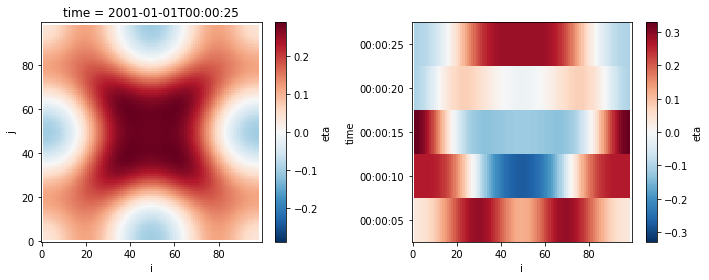

In [6]:
def plot_results(da):
    plt.subplot(121)
    da.isel(time=-1).plot()
    plt.subplot(122)
    da.isel(j=50).plot()
    plt.gcf().set_size_inches(10, 4)
    plt.tight_layout();
    
plot_results(eta)

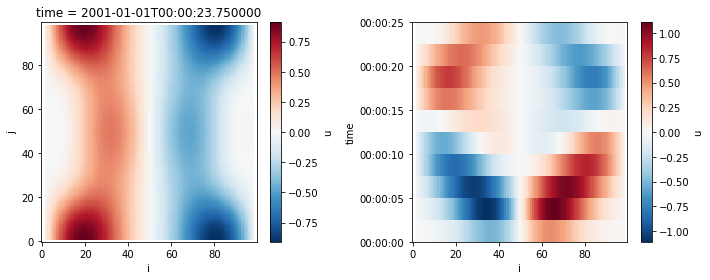

In [7]:
plot_results(u)

## Distributed Workflow

Now, the same diagnostic shall be performed, but the simulation workflow is now distributed using Dask. This has two major implications:
1. Instead of calling the diagnostic function on the full domain, it is called for each subdomain. This requires us to restructure `diag_output`. Now, we need to keep track of the state of the averaging for each subdomain.
2. The diagnostic function does not get the actual domain object as argument but instead a [future object](https://docs.dask.org/en/stable/futures.html) of that domain. To keep the execution on the cluster, ideally on the same worker where the data is, and to not interupt the computation on the cluster we need to submit the diagnostic functions to the cluster. We then collect the results [as they complete](https://docs.dask.org/en/stable/futures.html?distributed.as_completed#distributed.as_completed) to reduce the memory footprint of the cluster.

### Start up dask cluster to work on

We want to split the domain into 4 parts and start a worker for each subdomain. Each worker will have three threads to be able to do asynchroneous communication and diagostics.

In [8]:
from dask.distributed import Client

# monkey patch to speed up dask client
from functools import lru_cache
import inspect
inspect.getsource = lru_cache(inspect.getsource)

parts = 4
client = Client(
    n_workers=parts,
    threads_per_worker=3
)
client

distributed.nanny - ERROR - Failed to start worker
Traceback (most recent call last):
  File "/Users/mclaus/mambaforge/envs/multimodemodel/lib/python3.9/site-packages/distributed/nanny.py", line 878, in run
    await worker
  File "/Users/mclaus/mambaforge/envs/multimodemodel/lib/python3.9/site-packages/distributed/core.py", line 297, in _
    await self.start()
  File "/Users/mclaus/mambaforge/envs/multimodemodel/lib/python3.9/site-packages/distributed/worker.py", line 1548, in start
    self.start_http_server(routes, self._dashboard_address)
  File "/Users/mclaus/mambaforge/envs/multimodemodel/lib/python3.9/site-packages/distributed/node.py", line 161, in start_http_server
    self.http_server.listen(**tlz.merge(http_address, {"port": 0}))
  File "/Users/mclaus/mambaforge/envs/multimodemodel/lib/python3.9/site-packages/tornado/tcpserver.py", line 151, in listen
    sockets = bind_sockets(port, address=address)
  File "/Users/mclaus/mambaforge/envs/multimodemodel/lib/python3.9/site-pa

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 6,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65517,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:65530,Total threads: 3
Dashboard: http://127.0.0.1:65531/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:65520,


In [9]:
from multimodemodel import DaskWorkflow

workflow = DaskWorkflow(
    domain=make_initial_domain(make_c_grid()),
    solver=make_solver(),
    splitter=RegularSplitMerger(parts=parts, dim=(0,)),
    client=client
)

In [10]:
# used to collect futures and their results in the order they complete
from distributed import as_completed

results = as_completed()
state = dict(
    avg_u=[
        dict(
            buffer=None,
            start_int=workflow.domain.state.u.time,
            end_int=None,
            time_step=np.timedelta64(int(1000 * workflow.solver.step), "ms"),
        )
        for _ in range(parts)
    ]
)

def extract_from_tuple(future, index):
    return future[index]


def diag(domain: Domain) -> None:
    domain_id = workflow.domain_stack[-1].index(domain)
    results.add(client.submit(diag_snapshot, domain, "eta", interval=100))
    avg_future = client.submit(
        diag_average,
        domain, "u", interval=np.timedelta64(2500, "ms"), avg_state=state["avg_u"][domain_id]
    )
    state["avg_u"][domain_id] = client.submit(extract_from_tuple, avg_future, 0)
    results.add(client.submit(extract_from_tuple, avg_future, 1))

In [11]:
workflow.run(steps=500, diag=diag)

# collect results as they complete and drop None
results = [f.result() for f in results if f.result() is not None]

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
etas = (r for r in results if r.name == "eta")
reorder_eta = [list() for _ in range(parts)]
for r in etas:
    reorder_eta[r.id].append(r)
eta = xr.combine_nested(reorder_eta, concat_dim=["j", 'time'], combine_attrs="drop")

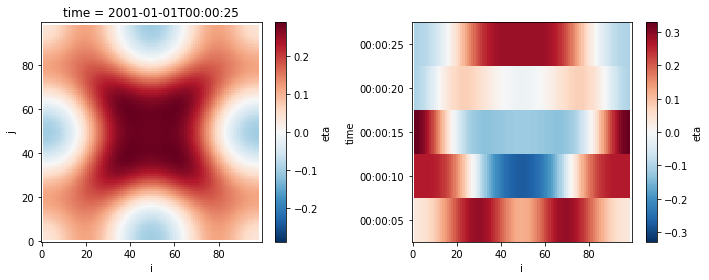

In [13]:
plot_results(eta)

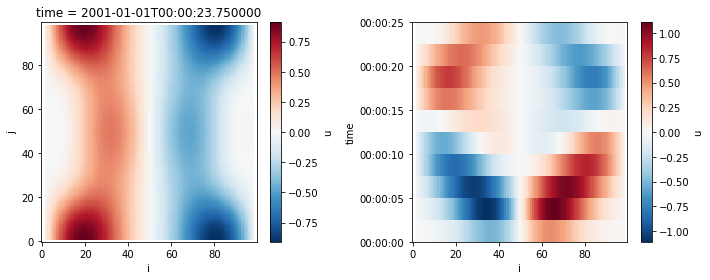

In [14]:
reorder_u = [list() for _ in range(parts)]
for r in (r for r in results if r.name == "u"):
    reorder_u[r.id].append(r)
u = xr.combine_nested(reorder_u, concat_dim=["j", 'time'], combine_attrs="drop")
plot_results(u)